In [19]:
# Uncomment the line below to install Aer package for custom depolarizing error
# !pip install qiskit-aer

In [20]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
import numpy as np
from qiskit.providers.fake_provider import FakeProvider
from qiskit.circuit.library import CZGate, RXGate, RYGate, UnitaryGate, TGate, XGate, YGate, CPhaseGate, HGate
from qiskit.quantum_info import Statevector, Operator, average_gate_fidelity
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_aer.noise import depolarizing_error, NoiseModel, thermal_relaxation_error, coherent_unitary_error
from scipy.linalg import sqrtm

In [21]:
# Define the gates
X90, Y90 = RXGate(np.pi / 2), RYGate(np.pi / 2)
T, X, Y, H = TGate(), XGate(), YGate(), HGate()
W = UnitaryGate((X.to_matrix()+Y.to_matrix())/np.sqrt(2), label='W')
SW = UnitaryGate(sqrtm(W.to_matrix()), label='SW')
XY90 = UnitaryGate((X90.to_matrix() + Y90.to_matrix()) / np.sqrt(3), label="XY90")
XY90mm = UnitaryGate((-X90.to_matrix() - Y90.to_matrix()) / np.sqrt(3), label="XY90mm")
XY90pm = UnitaryGate((X90.to_matrix() - Y90.to_matrix()), label="XY90pm")
XY90mp = UnitaryGate((-X90.to_matrix() + Y90.to_matrix()), label="XY90mp")
CZ, CP = CZGate(), CPhaseGate(np.pi/2)

# Possible gate sets
gate_dict1 = {0: X90, 1: Y90, 2: T}  # https://arxiv.org/abs/1608.00263
gate_dict2 = {0: X90, 1: Y90, 2: SW}  # https://www.nature.com/articles/s41586-019-1666-5
gate_dict3 = {0: X90, 1: Y90, 2: XY90, 3: XY90mm, 4: XY90pm, 5: XY90mp} # https://arxiv.org/abs/2001.08343
gate_dict4 = {0: X90, 1: Y90, 2: XY90} 
gate_sets = [gate_dict1, gate_dict2, gate_dict3, gate_dict4]

# Choose the gate set
gate_set_choice = 2 # 1, 2, 3 or 4
gate_dict = gate_sets[gate_set_choice - 1]
random_gates = len(gate_dict)

In [22]:
print('X90@T\n', X90.to_matrix()@T.to_matrix())
print('T@X90\n',T.to_matrix()@X90.to_matrix())
print('XY90\n',XY90.to_matrix())
print("SW\n", np.round(SW.to_matrix(), 5))
print(np.round(XY90.to_matrix(), 5))

X90@T
 [[0.70710678+0.j         0.5       -0.5j       ]
 [0.        -0.70710678j 0.5       +0.5j       ]]
T@X90
 [[0.70710678+0.j         0.        -0.70710678j]
 [0.5       -0.5j        0.5       +0.5j       ]]
XY90
 [[ 0.81649658+0.j         -0.40824829-0.40824829j]
 [ 0.40824829-0.40824829j  0.81649658+0.j        ]]
SW
 [[0.5    -0.5j     0.70711-0.j     ]
 [0.     +0.70711j 0.5    -0.5j    ]]
[[ 0.8165 +0.j      -0.40825-0.40825j]
 [ 0.40825-0.40825j  0.8165 +0.j     ]]


In [23]:

depol_error1 = depolarizing_error(0.001, 1)
depol_error2 = depolarizing_error(0.05, 2)
t1_err = thermal_relaxation_error(20, 10, 20)
coherent_err = coherent_unitary_error(RXGate(0.005*np.pi).to_matrix())
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depol_error1, ["h", "SW", 'ry', 'rx'])
noise_model.add_all_qubit_quantum_error(depol_error2, ["cz", "cp"])
noise_model.add_all_qubit_quantum_error(coherent_err, ["h", "SW", 'ry', 'rx'])
backend = AerSimulator(noise_model=noise_model) 
backend

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['cp', 'rx', 'cz', 'SW', 'ry', 'h']>)

In [24]:
# np.random.seed(335)
sequences = 30 # Number of sequences
max_depth = 200 # Maximum depth
step = 20 # Step for depths to be tested
depths = np.arange(2, max_depth + 1, step) # Depths to be tested
n_avgs = 1000 # Number of shots
np.random.seed(11211)
qubits = QuantumRegister(2, "q") # Number of qubits

sq_gates, counts_list, states_list, circuits_list = [], [], [], []  # 2D for 2 qubits

# Generate sequences
for s in range(sequences):  # For each sequence
    counts_list.append([])
    sq_gates.append([])
    circuits_list.append([])
    states_list.append([])
    for i, d in enumerate(depths):  # For each maximum depth
        sq_gates[s].append(np.zeros((2, d), dtype=int))
        for q in range(2):  # For each qubit
            # Generate random single qubit gates
            # Start the sequence with a random gate
            sq_gates[s][i][q][0] = np.random.randint(random_gates)
        for d_ in range(1, d):  # For each growing depth (all cycles until maximum depth d)
            for q in range(2):  # For each qubit
                sq_gates[s][i][q][d_] = np.random.randint(random_gates)
                # Make sure that the same gate is not applied twice in a row
                while sq_gates[s][i][q][d_] == sq_gates[s][i][q][d_ - 1]:
                    sq_gates[s][i][q][d_] = np.random.randint(random_gates)
        # Define the circuit
        qc = QuantumCircuit(qubits)
        # First cycle: apply Hadamard gatesthe o
        qc.append(H, [0])
        qc.append(H, [1])
        for d_ in range(d):  # Apply layers
            for q in range(2):  # For each qubit, append single qubit gates
                qc.append(gate_dict[sq_gates[s][i][q][d_]], [qubits[q]])
            # Apply CZ gate
            qc.append(CZ, qubits)
        # Store the statevector
        states_list[s].append(Statevector(qc))
        circuits_list[s].append(qc)
        

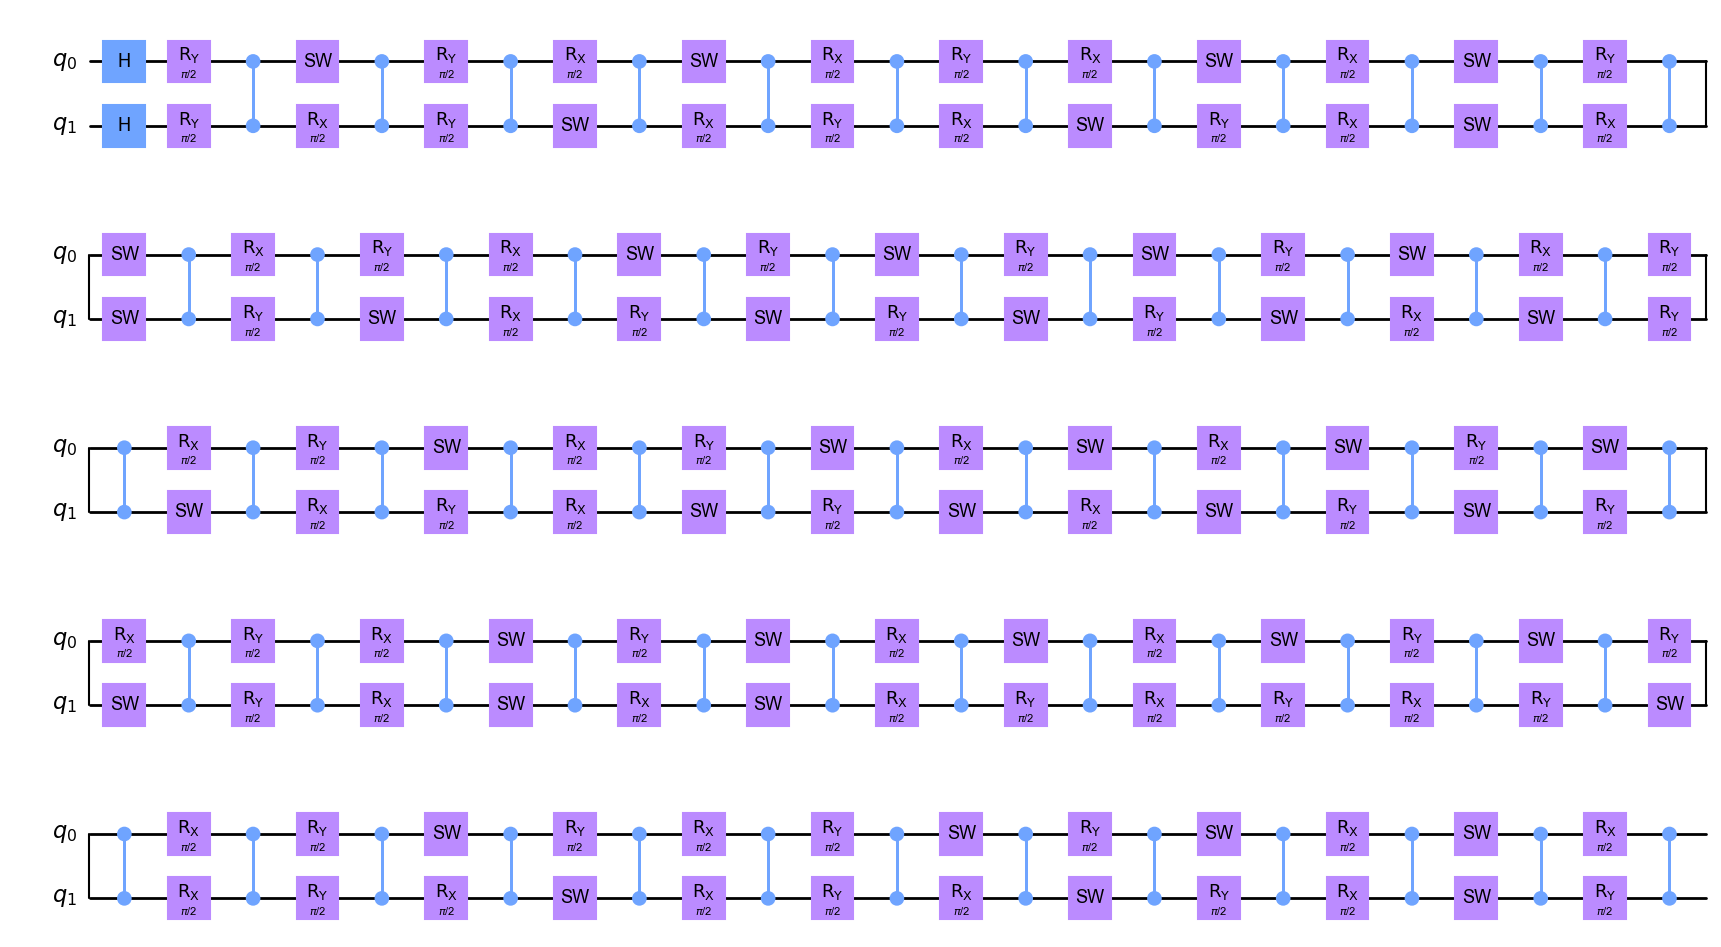

In [25]:
# Draw the circuit of your choice: first index is the sequence, second index is the depth index in depths array
circuits_list[1][3].draw(output="mpl", style='clifford')

In [26]:
# Execute circuit (transpiled) and store counts
for s in range(sequences):
    for i, d in enumerate(depths):
        qc2 = transpile(circuits_list[s][i].measure_all(inplace=False), backend)
        job = backend.run(qc2, shots=n_avgs)
        counts = job.result().get_counts()

        # Add missing keys to counts (Qiskit does not add all possible outcomes by default, only the ones carrying actual counts)
        for key in [bin(i)[2:].zfill(2) for i in range(2 ** len(qubits))]:
            if key not in counts.keys():
                counts[key] = 0
        # Add counts to list
        counts_list[s].append(counts)
        

In [27]:
def cross_entropy(p, q, epsilon=1e-15):
    """
    Calculate cross entropy between two probability distributions.

    Parameters:
    - p: numpy array, the true probability distribution
    - q: numpy array, the predicted probability distribution
    - epsilon: small value to avoid taking the logarithm of zero

    Returns:
    - Cross entropy between p and q
    """
    q = np.maximum(q, epsilon)  # Avoid taking the logarithm of zero

    # print(f"p: {p}, \nq: {q}")

    x_entropy = -np.sum(p * np.log(q))

    return x_entropy

In [28]:
from scipy.optimize import curve_fit
# Post-processing
records = []
incoherent_dist = np.ones(2** len(qubits)) / 2 ** len(qubits)
fidelities = np.zeros((sequences, len(depths)))
expected_probs = np.zeros((sequences, len(depths), 2 ** len(qubits)))
measured_probs = np.zeros((sequences, len(depths), 2 ** len(qubits)))

# Reconstruct sequence from gate indices (similar step to what is done in QUA)
for s in range(sequences):
    for j, d in enumerate(depths):
        qc = QuantumCircuit(qubits)
        qc.append(H, [0])
        qc.append(H, [1])
        for k in range(d):
            sq_gate1, sq_gate2 = (
                gate_dict[sq_gates[s][j][0][k]],
                gate_dict[sq_gates[s][j][1][k]],
            )
            # Retrieve random single qubit gates applied on both qubits
            # Apply the gates on the state
            qc.append(sq_gate1, [0])
            qc.append(sq_gate2, [1])
            qc.append(CZ, [0, 1])
            # print("computed state: %s" % state)
        expected_probs[s, j] = Statevector(qc).probabilities()
        # print("reconstructed probs", expected_probs[s, j])
        # print("state based probs", states_list[s][j].probabilities())
        measured_probs[s, j] = (
            np.array([counts_list[s][j][bit] for bit in ["00", "01", "10", "11"]])
            / n_avgs
        )
        # print("measured", measured_probs[s, j])
        xe_incoherent = cross_entropy(incoherent_dist, expected_probs[s, j])
        xe_measured = cross_entropy(measured_probs[s, j], expected_probs[s, j])
        xe_expected = cross_entropy(expected_probs[s, j], expected_probs[s, j])

        f_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
        fidelities[s, j] = f_xeb
        # print(f"seq {s + 1}, depth {depths[j]}: f_xeb = {f_xeb}")
        records += [
            {
                "sequence": s,
                "depth": depths[j],
                "pure_probs": expected_probs[s, j],
                # "pure_probs": states_list[s][j].probabilities(),
                "sampled_probs": measured_probs[s, j],
                "circuit": circuits_list[s][j],
            }
        ]

for record in records:
    e_u = np.sum(record["pure_probs"] ** 2)
    u_u = np.sum(record["pure_probs"]) / 2 ** len(qubits)
    m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
    record.update(e_u=e_u, u_u=u_u, m_u=m_u)

/var/folders/y8/9zgwllj55dbbch4pxmg_g7jm0000gn/T/ipykernel_4611/1554235115.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  f_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
/var/folders/y8/9zgwllj55dbbch4pxmg_g7jm0000gn/T/ipykernel_4611/1554235115.py:38: RuntimeWarning: invalid value encountered in scalar divide
  f_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)


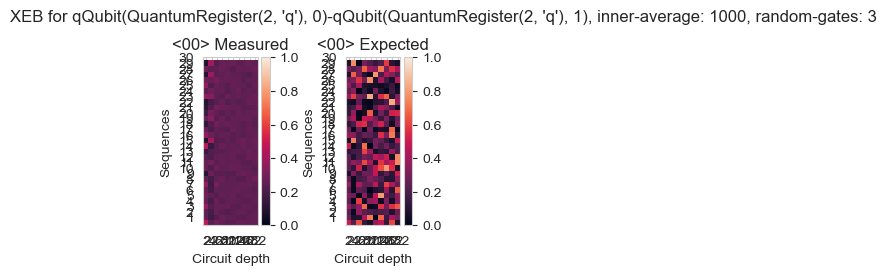

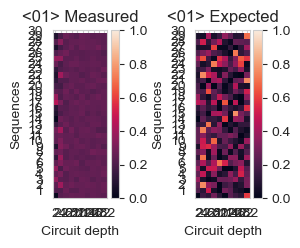

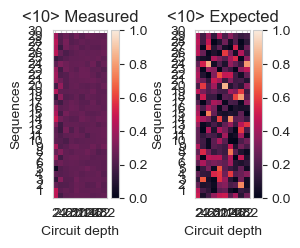

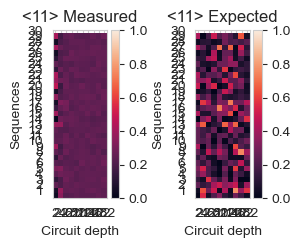

In [29]:
# Plot the results
def create_subplot(data, subplot_number, title):
    plt.subplot(subplot_number)
    plt.pcolor(depths, range(sequences), np.abs(data), vmin=0., vmax=1.0)
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("Circuit depth")
    ax.set_ylabel("Sequences")
    ax.set_xticks(depths)
    ax.set_yticks(np.arange(1, sequences + 1))
    plt.colorbar()

titles, data = [], []

for i in range(4):
    titles.append(f"<{bin(i)[2:].zfill(2)}> Measured")
    titles.append(f"<{bin(i)[2:].zfill(2)}> Expected")
    data.append(measured_probs[:, :, i])
    data.append(expected_probs[:, :, i])

plot_number = [241, 242, 243, 244, 245, 246, 247, 248]

k = 0
for title, d, n in zip(titles, data, plot_number):

    if k%2 == 0:
        plt.figure()
    if k==0:
            plt.suptitle(f"XEB for q{qubits[0]}-q{qubits[1]}, inner-average: {n_avgs}, random-gates: {3}")
    create_subplot(d, n, title)
    plt.subplots_adjust(wspace=1.1)
    k+=1


In [30]:
import pandas as pd
df = pd.DataFrame(records)
df["y"] = df["m_u"] - df["u_u"]
df["x"] = df["e_u"] - df["u_u"]

df["numerator"] = df["x"] * df["y"]
df["denominator"] = df["x"] ** 2
df

,sequence,depth,pure_probs,sampled_probs,circuit,e_u,u_u,m_u,y,x,numerator,denominator
0,0,2,"[0.4999999999999998, 5.046341745163241e-33, 0....","[0.474, 0.023, 0.466, 0.037]","((Instruction(name='h', num_qubits=1, num_clbi...",0.500000,0.25,0.470000,0.220000,0.250000,0.055000,0.062500
1,0,22,"[0.22492660923418456, 0.16370236276904623, 0.0...","[0.237, 0.231, 0.183, 0.349]","((Instruction(name='h', num_qubits=1, num_clbi...",0.376816,0.25,0.293125,0.043125,0.126816,0.005469,0.016082
2,0,42,"[0.6358152318591833, 0.11915477968710016, 0.18...","[0.287, 0.249, 0.243, 0.221]","((Instruction(name='h', num_qubits=1, num_clbi...",0.455902,0.25,0.270336,0.020336,0.205902,0.004187,0.042396
3,0,62,"[0.1395066511827914, 0.28585237717103673, 0.36...","[0.255, 0.263, 0.25, 0.232]","((Instruction(name='h', num_qubits=1, num_clbi...",0.278460,0.25,0.250647,0.000647,0.028460,0.000018,0.000810
4,0,82,"[0.06397960505491046, 0.1205640562944689, 0.47...","[0.232, 0.257, 0.264, 0.247]","((Instruction(name='h', num_qubits=1, num_clbi...",0.360939,0.25,0.255369,0.005369,0.110939,0.000596,0.012307
...,...,...,...,...,...,...,...,...,...,...,...,...
295,29,102,"[0.13969783060951224, 0.3629513945344309, 0.19...","[0.273, 0.267, 0.234, 0.226]","((Instruction(name='h', num_qubits=1, num_clbi...",0.280899,0.25,0.248999,-0.001001,0.030899,-0.000031,0.000955
296,29,122,"[0.21062292108778566, 0.24247537027556865, 0.3...","[0.242, 0.26, 0.268, 0.23]","((Instruction(name='h', num_qubits=1, num_clbi...",0.262578,0.25,0.252862,0.002862,0.012578,0.000036,0.000158
297,29,142,"[0.585994454370316, 0.09738485317904158, 0.217...","[0.243, 0.241, 0.256, 0.26]","((Instruction(name='h', num_qubits=1, num_clbi...",0.410095,0.25,0.247316,-0.002684,0.160095,-0.000430,0.025630
298,29,162,"[0.1059951873190802, 0.10423631616191753, 0.14...","[0.269, 0.246, 0.248, 0.237]","((Instruction(name='h', num_qubits=1, num_clbi...",0.457872,0.25,0.242936,-0.007064,0.207872,-0.001468,0.043211


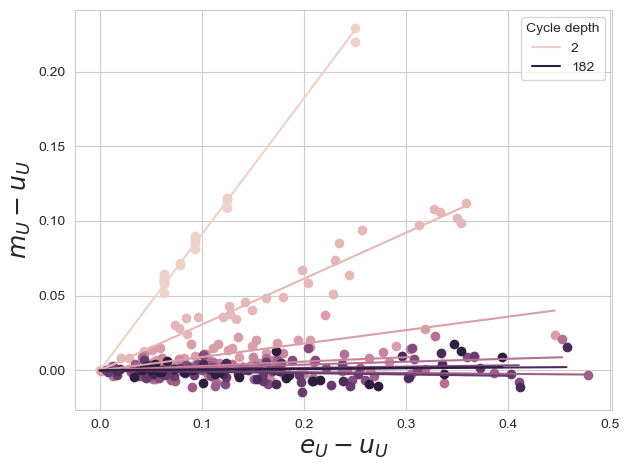

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt

# Color by cycle depth
import seaborn as sns

colors = sns.cubehelix_palette(n_colors=len(depths))
colors = {k: colors[i] for i, k in enumerate(depths)}

_lines = []


def per_cycle_depth(df):
    fid_lsq = df["numerator"].sum() / df["denominator"].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df["x"].max())
    (l,) = plt.plot(xx, fid_lsq * xx, color=colors[cycle_depth])
    plt.scatter(df["x"], df["y"], color=colors[cycle_depth])

    global _lines
    _lines += [l]  # for legend
    return pd.Series({"fidelity": fid_lsq})


fids = df.groupby("depth").apply(per_cycle_depth).reset_index()
plt.xlabel(r"$e_U - u_U$", fontsize=18)
plt.ylabel(r"$m_U - u_U$", fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0, -1]], depths[[0, -1]], loc="best", title="Cycle depth")
plt.tight_layout()

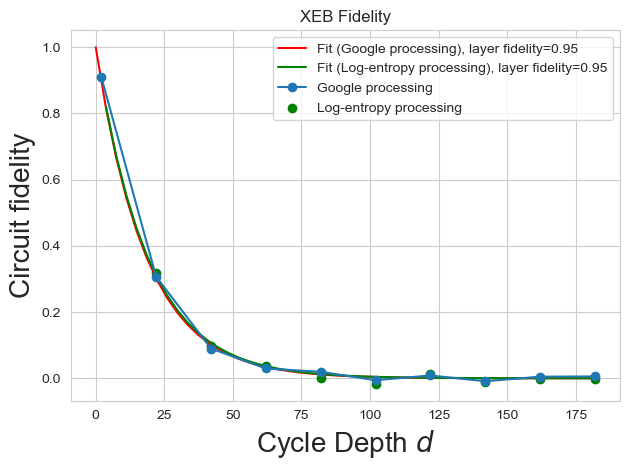

In [32]:
from typing import Tuple
from scipy import optimize
from scipy import stats


# Fit the data
def exponential_decay(cycle_depths: np.ndarray, a: float, layer_fid: float) -> np.ndarray:
    """An exponential decay for fitting.

    This computes `a * layer_fid**cycle_depths`

    Args:
        cycle_depths: The various depths at which fidelity was estimated. This is the independent
            variable in the exponential function.
        a: A scale parameter in the exponential function.
        layer_fid: The base of the exponent in the exponential function.
    """
    return a * layer_fid**cycle_depths

def _fit_exponential_decay(
    cycle_depths: np.ndarray, fidelities: np.ndarray
) -> Tuple[float, float, float, float]:
    """Fit an exponential model fidelity = a * layer_fid**x using nonlinear least squares.

    This uses `exponential_decay` as the function to fit with parameters `a` and `layer_fid`.

    Args:
        cycle_depths: The various depths at which fidelity was estimated. Each element is `x`
            in the fit expression.
        fidelities: The estimated fidelities for each cycle depth. Each element is `fidelity`
            in the fit expression.

    Returns:
        a: The first fit parameter that scales the exponential function, perhaps accounting for
            state prep and measurement (SPAM) error.
        layer_fid: The second fit parameters which serves as the base of the exponential.
        a_std: The standard deviation of the `a` parameter estimate.
        layer_fid_std: The standard deviation of the `layer_fid` parameter estimate.
    """
    cycle_depths = np.asarray(cycle_depths)
    fidelities = np.asarray(fidelities)

    # Get initial guess by linear least squares with logarithm of model.
    # This only works for positive fidelities. We use numpy fancy indexing
    # with `positives` (an ndarray of bools).
    positives = fidelities > 0
    if np.sum(positives) <= 1:
        # The sum of the boolean array is the number of `True` entries.
        # For one or fewer positive values, we cannot perform the linear fit.
        return 0, 0, np.inf, np.inf
    cycle_depths_pos = cycle_depths[positives]
    log_fidelities = np.log(fidelities[positives])

    slope, intercept, _, _, _ = stats.linregress(cycle_depths_pos, log_fidelities)
    layer_fid_0 = np.clip(np.exp(slope), 0, 1)
    a_0 = np.clip(np.exp(intercept), 0, 1)

    try:
        (a, layer_fid), pcov = optimize.curve_fit(
            exponential_decay,
            cycle_depths,
            fidelities,
            p0=(a_0, layer_fid_0),
            bounds=((0, 0), (1, 1)),
        )
    except ValueError:  # pragma: no cover
        return 0, 0, np.inf, np.inf

    a_std, layer_fid_std = np.sqrt(np.diag(pcov))
    return a, layer_fid, a_std, layer_fid_std

fit_google = True
fit_log_entropy = True
xx = np.linspace(0, fids["depth"].max())
# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    a, layer_fid, a_std, layer_fid_std = _fit_exponential_decay(fids["depth"], fids["fidelity"])
    plt.plot(xx, exponential_decay(xx, a, layer_fid),
         label='Fit (Google processing), layer fidelity={:.2f}'.format(layer_fid),
         color='red')
except:
    print("Fit for Google processing data failed")
    fit_google = False
Fxeb = np.mean(fidelities, axis=0)
try:
    a2, layer_fid2, a_std2, layer_fid_std2 = _fit_exponential_decay(depths[1:], Fxeb[1:])
    plt.plot(xx[1:], exponential_decay(xx[1:], a2, layer_fid2),
        label="Fit (Log-entropy processing), layer fidelity={:.2f}".format(layer_fid),
        color="green")
    
except:
    print("Fit for Log-entropy processing data failed")
    fit_log_entropy = False
    
    
plt.plot(fids["depth"], fids["fidelity"], marker="o", label="Google processing")

plt.scatter(depths, Fxeb, marker = 'o',
            color='green', label="Log-entropy processing")

plt.ylabel("Circuit fidelity", fontsize=20)
plt.xlabel("Cycle Depth $d$", fontsize=20)
plt.title("XEB Fidelity")
plt.legend(loc="best")
# plt.yscale("log")
plt.tight_layout()
plt.show()

In [33]:
if fit_google:
    print("Google processing fit:")
    print("Params: ", a, layer_fid)
    print("Error per cycle: ", layer_fid)
if fit_log_entropy:
    print("Log-entropy processing fit:")
    print("Params: ", a2, layer_fid2)
    print("Error per cycle: ", layer_fid2)

Google processing fit:
Params:  0.9999999999999999 0.9470683075397986
Error per cycle:  0.9470683075397986
Log-entropy processing fit:
Params:  0.9999999999999999 0.9482160317525848
Error per cycle:  0.9482160317525848


In [34]:
print(f"Currently used in the QM XEB example:\n {Fxeb}") # Derived from the fSim paper
print(f'Linear XEB of Google:\n {fids["fidelity"]}') # from Google's Supremacy paper

Currently used in the QM XEB example:
 [        nan  0.31887235  0.09902169  0.0376077  -0.00040883 -0.01694266
  0.01294566 -0.01214366 -0.00223963 -0.00208607]
Linear XEB of Google:
 0    0.910855
1    0.307054
2    0.089925
3    0.029568
4    0.019482
5   -0.005736
6    0.008474
7   -0.008957
8    0.004859
9    0.005580
Name: fidelity, dtype: float64


In [35]:
print("absolute difference", np.abs(fids["fidelity"] - Fxeb))

absolute difference 0         NaN
1    0.011819
2    0.009097
3    0.008040
4    0.019891
5    0.011206
6    0.004471
7    0.003187
8    0.007098
9    0.007666
Name: fidelity, dtype: float64


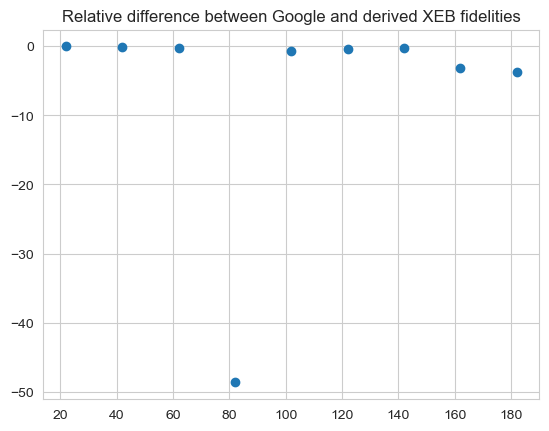

In [36]:
plt.title("Relative difference between Google and derived XEB fidelities")
plt.plot(depths, (fids["fidelity"]-Fxeb)/Fxeb, 'o', label="XEB fidelity")
